In [1]:
import numpy as np
import torch
import random
import os
from pytorch_lightning import seed_everything
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.metrics import roc_auc_score

SEED = 42
N_FOLDS = 5
TRAIN_FOLD = 0
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state


random_state = set_seed(SEED)

Global seed set to 42


In [2]:
train = pd.read_csv('./seti-breakthrough-listen/train_labels.csv')
test = pd.read_csv('./seti-breakthrough-listen/sample_submission.csv')

def get_train_file_path(image_id):
    return "./seti-breakthrough-listen/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "./seti-breakthrough-listen/test/{}/{}.npy".format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head(20))

,id,target,file_path
0,00034abb3629,0,./seti-breakthrough-listen/train/0/00034abb362...
1,0004300a0b9b,0,./seti-breakthrough-listen/train/0/0004300a0b9...
2,000453852fda,0,./seti-breakthrough-listen/train/0/000453852fd...
3,00047dfc96a9,0,./seti-breakthrough-listen/train/0/00047dfc96a...
4,0004be0baf70,0,./seti-breakthrough-listen/train/0/0004be0baf7...
5,0005be4d0752,0,./seti-breakthrough-listen/train/0/0005be4d075...
6,0006457aa591,0,./seti-breakthrough-listen/train/0/0006457aa59...
7,0008fcc2f87d,0,./seti-breakthrough-listen/train/0/0008fcc2f87...
8,0009a92c4b1c,0,./seti-breakthrough-listen/train/0/0009a92c4b1...
9,000a6d98b0e4,0,./seti-breakthrough-listen/train/0/000a6d98b0e...


# get sub

In [3]:
sub0 = pd.read_csv('sub_seed42_fold0.csv')
sub1 = pd.read_csv('sub_seed42_fold1.csv')
sub2 = pd.read_csv('sub_seed42_fold2.csv')
sub3 = pd.read_csv('sub_seed42_fold3.csv')
sub4 = pd.read_csv('sub_seed42_fold4.csv')

In [4]:
sub = sub0.copy()
sub['target']  = sub0['target']+sub1['target']+sub2['target']+sub3['target']+sub4['target']
sub['target'] /= 5
sub['target']

0        0.014268
1        0.010356
2        0.057348
3        0.031380
4        0.011282
           ...   
35842    0.004217
35843    0.021284
35844    0.010877
35845    0.007482
35846    0.008737
Name: target, Length: 35847, dtype: float64

In [5]:
sub[sub['target']>0.5]

,id,target
18,001d7eb3f9cb,0.721702
20,001ff76166aa,0.829784
27,002d5868b367,0.638410
35,003954c7e391,0.779616
37,003b5326af50,0.566032
...,...,...
35820,ffcdb44aab9b,0.808111
35822,ffd062e29fe5,0.794242
35833,ffe37439d388,0.877124
35836,ffe6f31dcb95,0.904207


In [6]:
sub['target'].max(),sub['target'].min()

(0.938095856, 0.000450487284)

<AxesSubplot:ylabel='Density'>

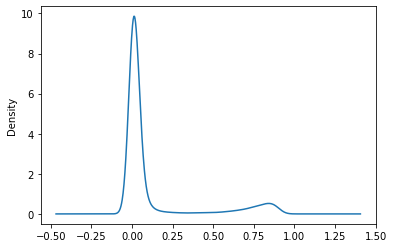

In [7]:
sub['target'].plot(kind='kde')

# get oof

In [8]:
oof0 = pd.read_csv('oof_seed42_fold0.csv')
oof1 = pd.read_csv('oof_seed42_fold1.csv')
oof2 = pd.read_csv('oof_seed42_fold2.csv')
oof3 = pd.read_csv('oof_seed42_fold3.csv')
oof4 = pd.read_csv('oof_seed42_fold4.csv')

In [9]:
oof = pd.concat([oof0,oof1,oof2,oof3,oof4],axis=0)
a = train.set_index('id')
b = oof.set_index('id')
oof = b.loc[a.index].reset_index()
oof

,id,target,file_path,fold,preds
0,00034abb3629,0,./seti-breakthrough-listen/train/0/00034abb362...,4,0.005463
1,0004300a0b9b,0,./seti-breakthrough-listen/train/0/0004300a0b9...,3,0.017906
2,000453852fda,0,./seti-breakthrough-listen/train/0/000453852fd...,0,0.041585
3,00047dfc96a9,0,./seti-breakthrough-listen/train/0/00047dfc96a...,1,0.003460
4,0004be0baf70,0,./seti-breakthrough-listen/train/0/0004be0baf7...,4,0.139507
...,...,...,...,...,...
50160,fff395e32a1e,0,./seti-breakthrough-listen/train/f/fff395e32a1...,1,0.002717
50161,fff66bbc51db,0,./seti-breakthrough-listen/train/f/fff66bbc51d...,4,0.002301
50162,fffaf1658eb7,0,./seti-breakthrough-listen/train/f/fffaf1658eb...,4,0.028246
50163,fffb0fc8c613,0,./seti-breakthrough-listen/train/f/fffb0fc8c61...,0,0.008893


<AxesSubplot:ylabel='Density'>

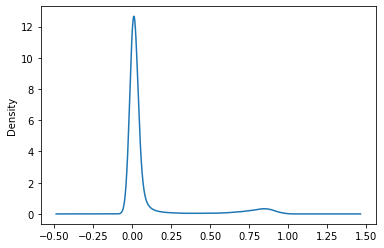

In [10]:
oof['preds'].plot(kind='kde')

In [11]:
a = train.id.values == oof.id.values
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{True: 50165}

# level2 model

In [12]:
from sklearn.linear_model import LogisticRegressionCV

X = oof[['preds']].values
y = oof[['target']].values
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)
clf.score(X, y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.985208810923951

# final_prob

In [13]:
final_prob = clf.predict_proba(sub[['target']].values)
final_df = sub.copy()
final_df['target'] = 1-final_prob
final_df

,id,target
0,00034db451c4,0.008650
1,0006316b5ca0,0.008178
2,0006a953d21b,0.016027
3,0008a33d6695,0.011057
4,00095b5119fc,0.008287
...,...,...
35842,ffeed3a168de,0.007487
35843,fff177e32aac,0.009567
35844,fff7d40b225a,0.008239
35845,fff8238a709f,0.007847


<AxesSubplot:ylabel='Density'>

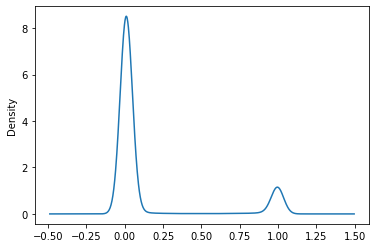

In [14]:
final_df['target'].plot(kind='kde')

In [15]:
final_df[final_df['target']>0.5]

,id,target
18,001d7eb3f9cb,0.995963
20,001ff76166aa,0.999154
27,002d5868b367,0.986631
35,003954c7e391,0.998251
37,003b5326af50,0.962771
...,...,...
35820,ffcdb44aab9b,0.998842
35822,ffd062e29fe5,0.998585
35833,ffe37439d388,0.999574
35836,ffe6f31dcb95,0.999712


In [16]:
final_df.to_csv('stacking_5fold_byLogisticRegressionCV.csv',index=False)